# Diamond Price Modelling

This is my first ever machine learning project. I will be applying what I've learnt so far (since 2 weeks) on this data set.

In this notebook, we will explore the factors that affect the price of a diamond with a goal of finding a model to help predict the price of diamonds.

### Notice
- The problem is requires **Supervised Learning**. The instances come with an expected output (*i.e* **the diamond's price**).
- Predicting the price of a diamond from dataset is a **Regression Task**. More specifically, a **Multivariate Regression Task**.
- We will be using the **Batch Learning** technique since the data is not live-fed from a source.
- We will also be the **Root Mean Square Error (RMSE)** for our performance measure (typical for Regression tasks).

**If you like this notebook, please up-vote! It keeps me motivated. Thank you! :)**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Load the diamond's dataset
diamonds = pd.read_csv("./diamonds.csv")

## Take a quick look at the Data Structure

Let's take a quick look at our diamonds dataset.

In [2]:
# Preview the top (five) rows of the dataset
diamonds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


A little more information about our dataset.

In [3]:
# Preview the little information about dataset
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
Unnamed: 0    53940 non-null int64
carat         53940 non-null float64
cut           53940 non-null object
color         53940 non-null object
clarity       53940 non-null object
depth         53940 non-null float64
table         53940 non-null float64
price         53940 non-null int64
x             53940 non-null float64
y             53940 non-null float64
z             53940 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


Noticed an unnecessary column `Unnamed: 0`. It just acts as index, it is not needed, thus that needs to be dropped.

In [4]:
# Drop the "Unnamed: 0" column
diamonds = diamonds.drop("Unnamed: 0", axis = 1)

# Price is int64, best if all numeric attributes have the same datatype, especially as float64
diamonds["price"] = diamonds["price"].astype(float)

# Preview dataset again
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75


There are **53490** instances in the dataset. There are also no missing instances in the dataset. *That looks clean!*

It's easier to work a dataset when all its attributes are numerical. The **cut**, **color** and **clarity** attributes are non-numeric (They are *objects*). We still have to convert them to be numerical.

Let's find out what categories exist for each of them.

In [5]:
# The diamond cut categories
diamonds["cut"].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [6]:
# The diamond color categories
diamonds["color"].value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [7]:
# The diamond clarity categories
diamonds["clarity"].value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

They each don't have so many categories, but still, we will be having a much longer table (*more columns*). That aside for now.

Let's take a preview of the summary of the numerical attributes and then an histogram on the dataset.

In [8]:
# Summary of each numerical attribute
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


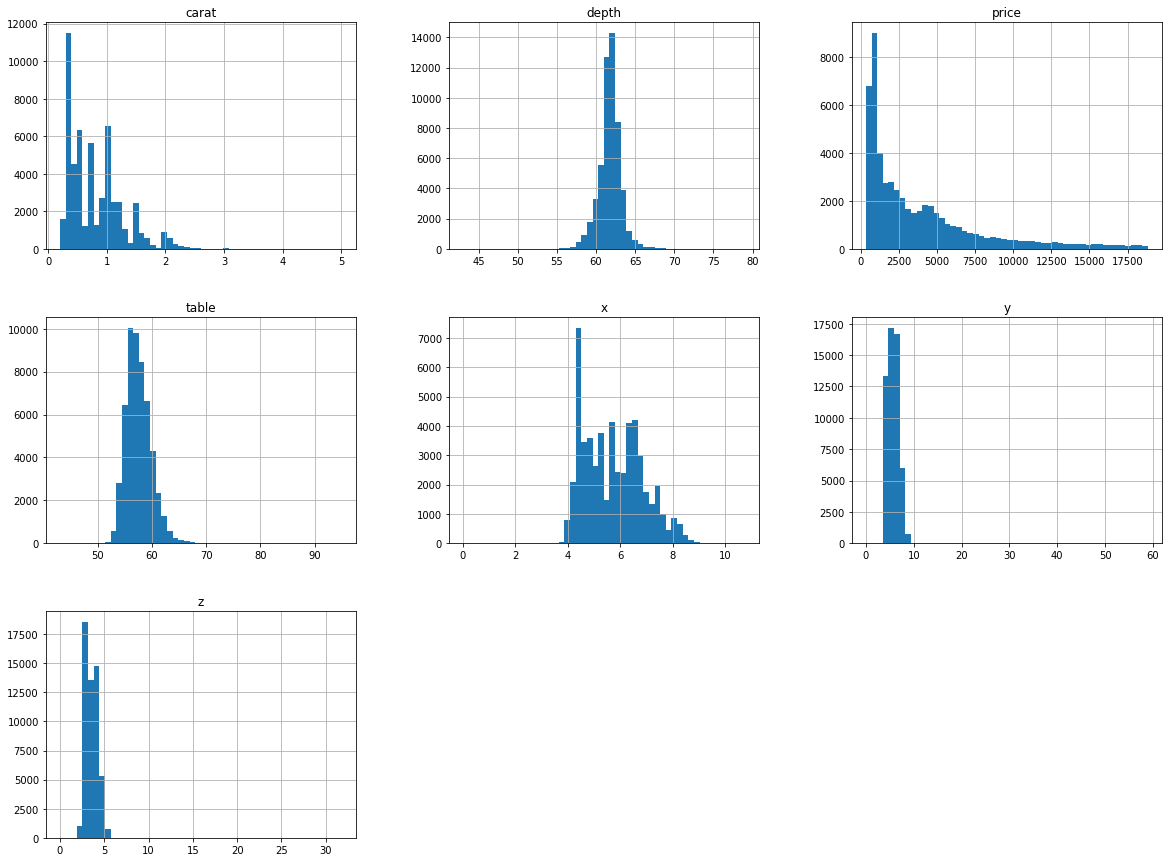

In [9]:
diamonds.hist(bins = 50, figsize = (20, 15))
plt.show()

Okay good! But what about the categorical attributes? What happens to them now? We are still going to make out a solution for them. But there's also something important we have to do and that is **"Creating a Test Set"**.

## Create a Test Set

I've learnt it is a good practice to separate your **Train Set** and **Test Set** (80% and 20% from your dataset respectively). The Test set will make us see our model's performance on the new instances.

That's clear! **But**, even though we want to do this, it doesn't feel right taking purely random samples of the dataset, else we could introduce a significant **Sampling Bias**. A good solution is by performing **Stratified Sampling**. The dataset will be divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall dataset. (*Hopefully, that's clear enough*)

To use this, we will need a very important attribute of the dataset to predict the of the diamond. How can we try select the attribute even though the team of those who gave you data didn't give you a clue? This is where we need to know the attributes that are most correlated to the price of the diamond. We use the **Standard Correlation Coefficient** (Pearson's r) to determine.

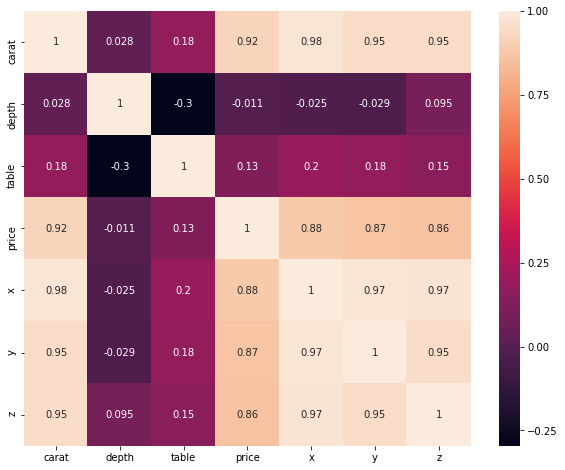

In [10]:
# Create a correlation matrix between every pair of attributes
corr_matrix = diamonds.corr()

# Plot the correlation with seaborn
plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True)
plt.show()

From the plot above, we could deduce that:
- `x`, `y`, `z` have strong correlations with `price`
- `carat` has the strongest correlation with `price` (0.92)
- `table` and `depth` have the weakest correlations

It is amazing so see that `carat` correlates best with price. Its score is pretty high! Now we use this for our *Stratified Sampling*.

Let's take a closer look at the `carat`'s histogram.

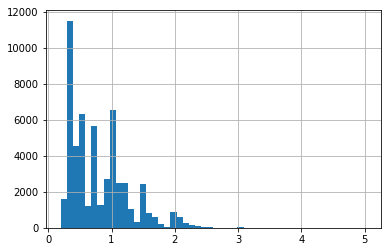

In [11]:
diamonds["carat"].hist(bins = 50)
plt.show()

Most diamonds are roughly between 0.3 and 1.5 Carats. Let's divide them into 5 categories, with those more than the 5th category merging into the 5th category.

In [12]:
# Divide the diamond carats by 0.4 to limit the number of carat categories
# Round up to have discrete categories
diamonds["carat_cat"] = np.ceil(diamonds["carat"] / 0.35)

# Merge categories > 5 in 5
diamonds["carat_cat"].where(diamonds["carat_cat"] < 5, 5.0, inplace = True)

Now let's see how much the diamonds are distributed in relation to the carat categories.

In [13]:
# Check the distribution of the diamonds in the categories
diamonds["carat_cat"].value_counts()

2.0    16104
3.0    13399
1.0    11058
4.0     6970
5.0     6409
Name: carat_cat, dtype: int64

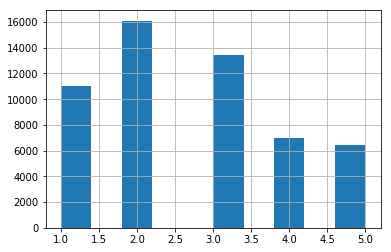

In [14]:
diamonds["carat_cat"].hist()
plt.show()

The distribution looks nice enough.

**PS:** I adjusted the divisor of `carat` until the distribution of the diamonds looked nice. *You could comment if you have any other ideas to doing this* :)

And yup! We can now perform a Stratified Sampling based on the carat categories :) I will use Scikit-Learn's `StratifiedShuffleSplit` class.

In [15]:
# Import the sklearn module
from sklearn.model_selection import StratifiedShuffleSplit

# Run the split. Creates on split and shares 20% of the dataset for the test set
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# Separate the stratified train set and the test set
for train_index, test_index in split.split(diamonds, diamonds["carat_cat"]):
    strat_train_set = diamonds.loc[train_index]
    strat_test_set = diamonds.loc[test_index]

We now have our Train set and Test set, both stratified. From here, we don't need the `carat_cat` anylonger, hence we can drop it.

In [16]:
for set in (strat_train_set, strat_test_set):
    set.drop(["carat_cat"], axis = 1, inplace = True)

Our new `diamonds` dataset will now be the *Stratified Train set*.

In [17]:
# Redefined diamonds dataset
diamonds = strat_train_set.copy()
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
7663,1.06,Ideal,I,SI2,61.8,57.0,4270.0,6.57,6.60,4.07
25971,1.51,Premium,G,VVS2,60.9,58.0,15164.0,7.38,7.42,4.51
33471,0.32,Ideal,F,VS2,61.3,56.0,828.0,4.43,4.41,2.71
44281,0.53,Ideal,G,VS2,61.2,56.0,1577.0,5.19,5.22,3.19
53007,0.70,Premium,H,VVS2,61.0,57.0,2596.0,5.76,5.72,3.50


## Data Visualization

Let's play around with some visualization of our dataset and make some observations out of it.

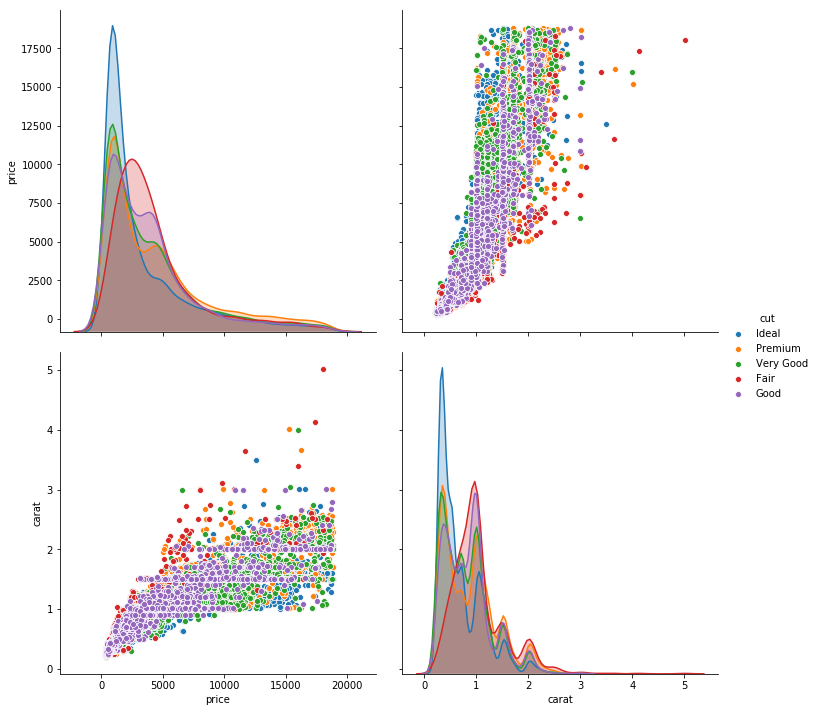

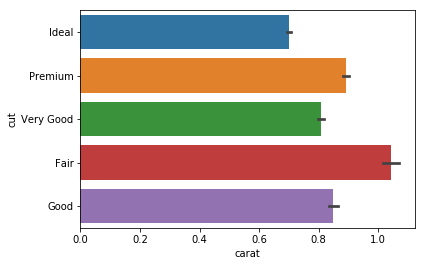

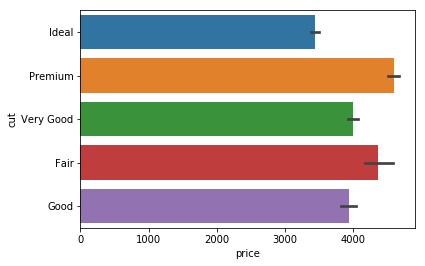

In [18]:
sns.pairplot(diamonds[["price", "carat", "cut"]], hue = "cut", height = 5)
plt.show()
sns.barplot(x = "carat", y = "cut", data = diamonds)
plt.show()
sns.barplot(x = "price", y = "cut", data = diamonds)
plt.show()

`Fair` cuts are most weighed, but they aren't the most expensive diamonds. `Premium` cuts weigh less than the fair and then cost more. `Ideal` cuts weigh way less and they are least expensive. The cut therefore is relatively considered while determining the price of the diamond.

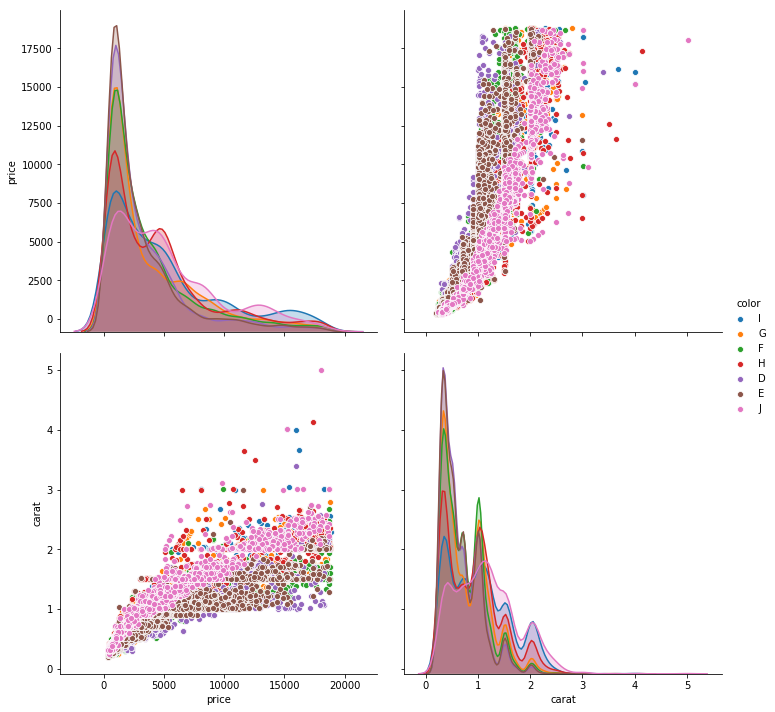

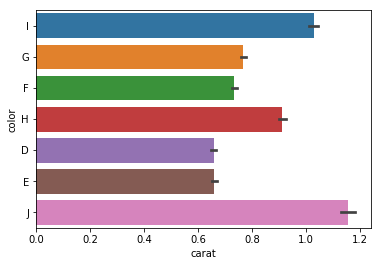

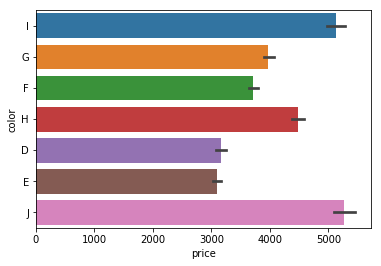

In [19]:
sns.pairplot(diamonds[["price", "carat", "color"]], hue = "color", height = 5)
plt.show()
sns.barplot(x = "carat", y = "color", data = diamonds)
plt.show()
sns.barplot(x = "price", y = "color", data = diamonds)
plt.show()

Here, we could see that the color `J` which is the most weighed is also the most priced. The last 2 plots are very similar. We could see here that the color of the diamond is also very dependent on its price.

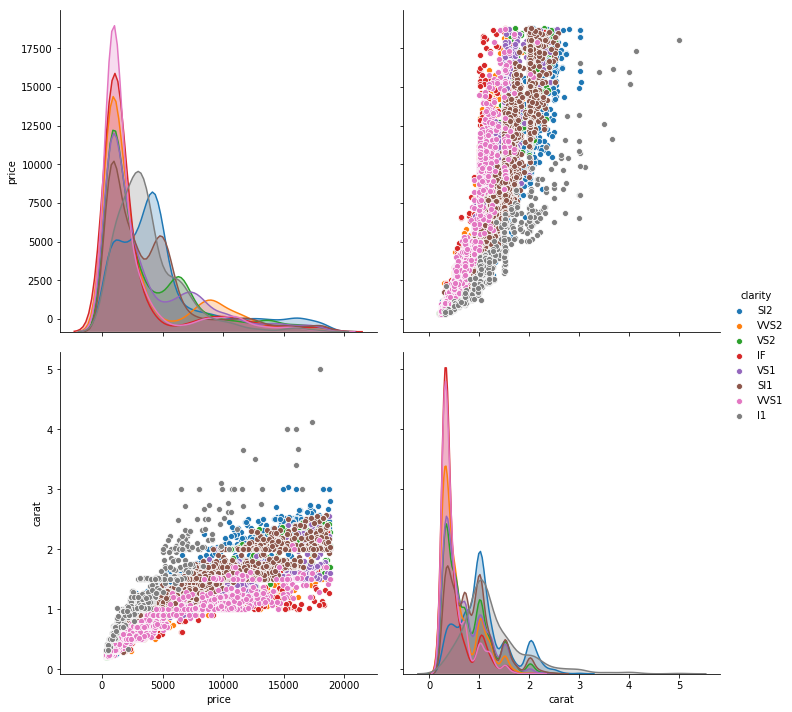

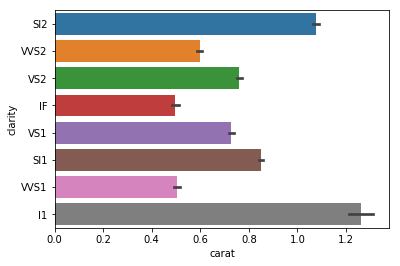

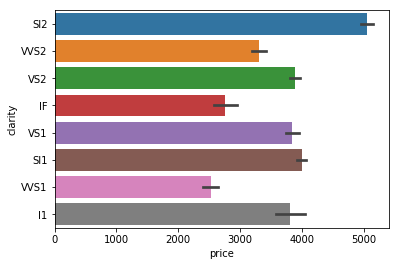

In [20]:
sns.pairplot(diamonds[["price", "carat", "clarity"]], hue = "clarity", height = 5)
plt.show()
sns.barplot(x = "carat", y = "clarity", data = diamonds)
plt.show()
sns.barplot(x = "price", y = "clarity", data = diamonds)
plt.show()

Here, we could see that `I1` doesn't hold the highest clarity, even though it is the most priced. But there's something else: Apart from `I1`, if the rest stays, the price of a diamond could **fairly** be relative to its clarity, to some extent.

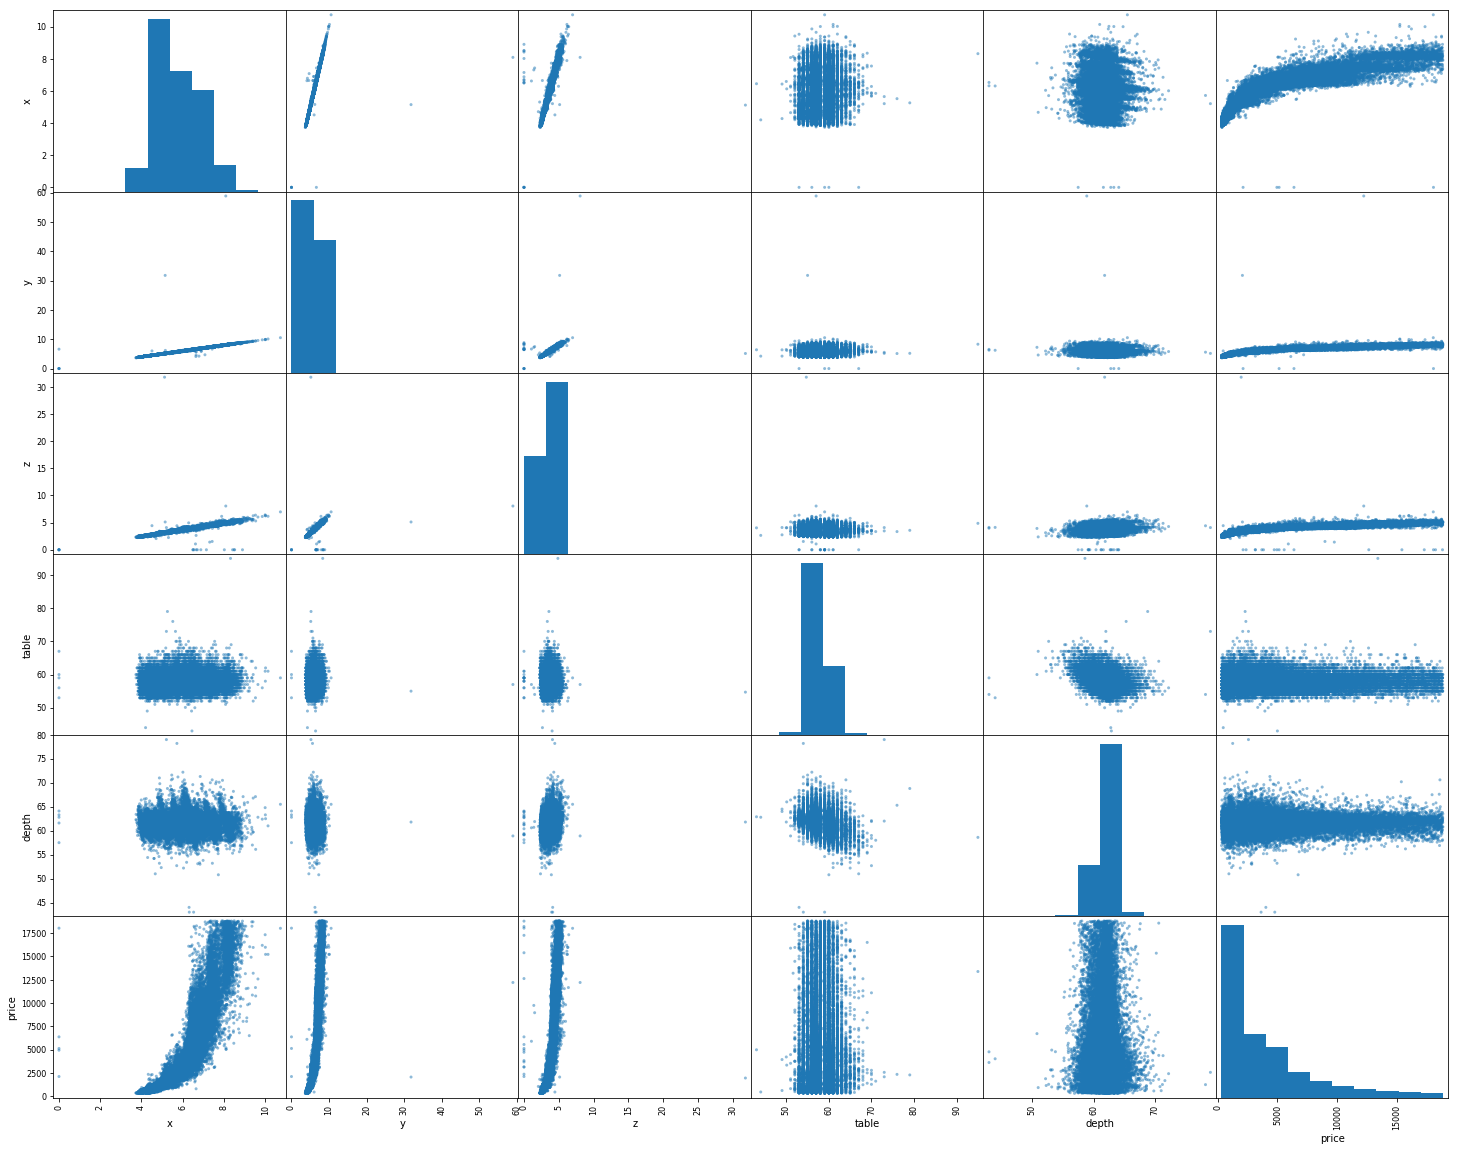

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["x", "y", "z", "table", "depth", "price"]
scatter_matrix(diamonds[attributes], figsize=(25, 20))
plt.show()

These visualizations have been met by our theories during correlation. And it's very obvious here that depth and table have very weak correlation with price.

## Feature Scaling

With few exceptions, Machine Learning algrorithms don't perform well when the input numerical attributes have very different scales. We sure want our models to work well, so how can we go about it?

Feature scaling can be done in 2 ways: **Min-max scaling** and **Standardization**. I would preferably use Standardization, because it is much less affected by outliers. Scikit-Learn provides a transformer called `StandardScaler` for this transformation.

**PS:** You don't stratify your label, which is in our case `price`.

In [22]:
# Do not stratify the label
diamonds = strat_train_set.drop("price", axis = 1)

# Set a new dataset label variable
diamond_labels = strat_train_set["price"].copy()

# Drop all the category, so we could have only numeric
diamonds_num = diamonds.drop(["cut", "color", "clarity"], axis = 1)
diamonds_num.head()

,carat,depth,table,x,y,z
7663,1.06,61.8,57.0,6.57,6.60,4.07
25971,1.51,60.9,58.0,7.38,7.42,4.51
33471,0.32,61.3,56.0,4.43,4.41,2.71
44281,0.53,61.2,56.0,5.19,5.22,3.19
53007,0.70,61.0,57.0,5.76,5.72,3.50


In [23]:
from sklearn.preprocessing import StandardScaler

# Perform the feature scaling on the numeric attributes of the dataset
num_scaler = StandardScaler()
diamonds_num_scaled = num_scaler.fit_transform(diamonds_num)

# Preview 
pd.DataFrame(diamonds_num_scaled).head()

,0,1,2,3,4,5
0,0.553529,0.036799,-0.205180,0.747755,0.752947,0.750367
1,1.503722,-0.590188,0.242472,1.470153,1.466739,1.371635
2,-1.009010,-0.311527,-0.652832,-1.160802,-1.153397,-1.169914
3,-0.565586,-0.381192,-0.652832,-0.482997,-0.448311,-0.492168
4,-0.206625,-0.520523,-0.205180,0.025357,-0.013072,-0.054456


That is what our data *will* look like during its processing. That's for the Machine Learning algorithm.

## Handling Categorical Attributes

From above, we split the columns of our dataset, putting aside the category attributes. Remember we still wanted to convert these attributes to numericaal attributes. How to we go about this?

We create one binary attribute per category: one attribute will be one while the rest will be 0. This is called **One-Hot Encoding**. Scikit-Learn provides a `OneHotEncoder` encoder to convert our category attributes to One-Hot vectors.

In [24]:
# We need only the category attributes to work with here
diamonds_cat = diamonds[["cut", "color", "clarity"]]
diamonds_cat.head()

,cut,color,clarity
7663,Ideal,I,SI2
25971,Premium,G,VVS2
33471,Ideal,F,VS2
44281,Ideal,G,VS2
53007,Premium,H,VVS2


In [25]:
from sklearn.preprocessing import OneHotEncoder

# Perform the one-hot encoding on the category attributes of the dataset
cat_encoder = OneHotEncoder()
diamonds_cat_encoded = cat_encoder.fit_transform(diamonds_cat)

# Convert the encoded categories to arrays and Preview
pd.DataFrame(diamonds_cat_encoded.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now that's what I meant by a longer table. What do we do next?

## Transformation Pipeline
We have our tables reformed, what we do now to to merge the numeric feature scaled attributes and the encoded category attributes. An easy way to do this without writing so much like above is to Scikit-Learn's `ColumnTransformer` class. This merging provides a single pipeline for the whole dataset.

In [26]:
from sklearn.compose import ColumnTransformer

num_attribs = list(diamonds_num)
cat_attribs = ["cut", "color", "clarity"]

# Pipeline to transform our dataset
pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs), # Perform feaured scaling on numeric attributes
    ("cat", OneHotEncoder(), cat_attribs) # Perform One-Hot encoding on the category attributes
])

In [27]:
# Transformed dataset to feed the ML Algorithm
diamonds_ready = pipeline.fit_transform(diamonds)

# Preview
pd.DataFrame(diamonds_ready).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.553529,0.036799,-0.205180,0.747755,0.752947,0.750367,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.503722,-0.590188,0.242472,1.470153,1.466739,1.371635,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.009010,-0.311527,-0.652832,-1.160802,-1.153397,-1.169914,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.565586,-0.381192,-0.652832,-0.482997,-0.448311,-0.492168,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.206625,-0.520523,-0.205180,0.025357,-0.013072,-0.054456,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We now have our newly transformed dataset that can easily be fed to our Machine Learning Algorithms.

## Select and Train Model

We will create one function that will run through each algorithm. We'll also have variables that hold results of the algorithms for future comparisons. What does our fat function do?

- Fits the dataset into the model and create series of predictions to compare with labels. We check its performance with the **RMSE**.

- Performs some evaluation using Cross validation, which splits the training set into a number of CVs and train the model on the smaller sets. We then compare its mean with our intial RMSE.

- We view how well the model performs on our test set and compare its RMSE with that of the train set. Hopefully we don't have much difference.

- Some accuracy test of the model on the dataset is being evaluated

- We could also have a preview of what's going on. Some parts of the test set will be selected and then the model will run on them and we can then compare its result with the expected prices.

- We also get a preview this model's plot results and see how well it fits

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from random import randint

# Our test set

# Remove label from test set
X_test = strat_test_set.drop("price", axis = 1)
# Have label stand alone
y_test = strat_test_set["price"].copy()

# Our models performance holder
models_rmse = [] # Holds Models original RMSE
cvs_rmse_mean = [] # Holds the Cross Validation RMSE Mean
tests_rmse = [] # Holds the tests RMSE
tests_accuracy = [] # Holds the tests accuracy
models = [] # Holds the models name

def display_model_performance(model_name, model, diamonds = diamonds_ready, labels = diamond_labels,
                              models_rmse = models_rmse, cvs_rmse_mean = cvs_rmse_mean, tests_rmse = tests_rmse,
                              tests_accuracy = tests_accuracy, pipeline = pipeline, X_test = X_test,
                              y_test = y_test, cv = True):
    # Fit dataset in model
    model.fit(diamonds, labels)
    
    # Setup predictions
    predictions = model.predict(diamonds)
    
    # Get models performance
    model_mse = mean_squared_error(labels, predictions)
    model_rmse = np.sqrt(model_mse)
    
    # Cross validation
    cv_score = cross_val_score(model, diamonds, labels, scoring = "neg_mean_squared_error", cv = 10)
    cv_rmse = np.sqrt(-cv_score)
    cv_rmse_mean = cv_rmse.mean()
    
    print("RMSE: %.4f" %model_rmse)
    models_rmse.append(model_rmse)
    
    print("CV-RMSE: %.4f" %cv_rmse_mean)
    cvs_rmse_mean.append(cv_rmse_mean)
    
    print("--- Test Performance ---")
    
    X_test_prepared = pipeline.transform(X_test)
    
    # Fit test dataset in model
    model.fit(X_test_prepared, y_test)
    
    # Setup test predictions
    test_predictions = model.predict(X_test_prepared)
    
    # Get models performance on test
    test_model_mse = mean_squared_error(y_test, test_predictions)
    test_model_rmse = np.sqrt(test_model_mse)
    print("RMSE: %.4f" %test_model_rmse)
    tests_rmse.append(test_model_rmse)
    
    # Tests accuracy
    test_accuracy = round(model.score(X_test_prepared, y_test) * 100, 2)
    print("Accuracy:", str(test_accuracy)+"%")
    tests_accuracy.append(test_accuracy)
    
    # Check how well model works on Test set by comparing prices
    start = randint(1, len(y_test))
    some_data = X_test.iloc[start:start + 7]
    some_labels = y_test.iloc[start:start + 7]
    some_data_prepared = pipeline.transform(some_data)
    print("Predictions:\t", model.predict(some_data_prepared))
    print("Labels:\t\t", list(some_labels))
    
    models.append(model_name)
    
    # Preview plot
    plt.scatter(diamond_labels, model.predict(diamonds_ready))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    plt.plot(x_lim, y_lim, "k--")
    plt.show()
    
    print("------- Test -------")
    plt.scatter(y_test, model.predict(X_test_prepared))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.plot(x_lim, y_lim, "k--")
    plt.show()

We can now start fitting models and get their performance error. Remember we are using **Root Mean Squared Error** for our performance measure.

Let's start with the easiest model - `Linear Regression`

### Linear Regression

RMSE: 1124.8137
CV-RMSE: 1126.3756
--- Test Performance ---
RMSE: 1142.2563
Accuracy: 91.87%
Predictions:	 [  648.  3400.  6208.  4738.   796.  3300. 10752.]
Labels:		 [521.0, 2433.0, 5001.0, 4725.0, 1795.0, 2247.0, 12756.0]


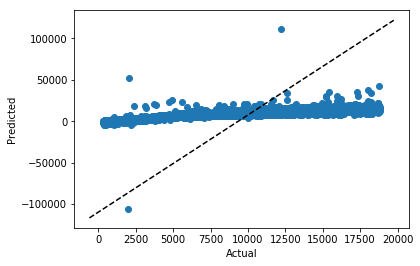

------- Test -------


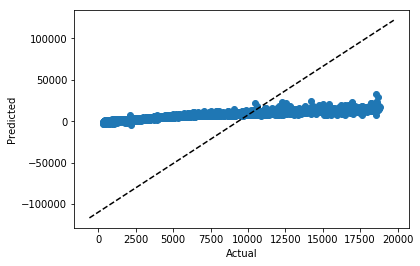

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize = True)
display_model_performance("Linear Regression", lin_reg)

### Decision Tree Regression

RMSE: 8.6134
CV-RMSE: 742.1458
--- Test Performance ---
RMSE: 6.5552
Accuracy: 100.0%
Predictions:	 [14171. 13784.  1624.   696.   552.  1163.  2660.]
Labels:		 [14171.0, 13784.0, 1624.0, 696.0, 552.0, 1163.0, 2660.0]


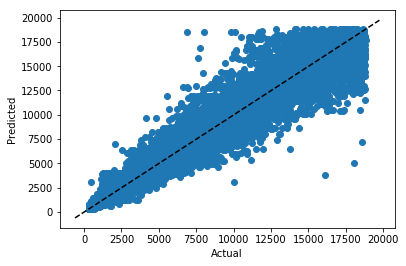

------- Test -------


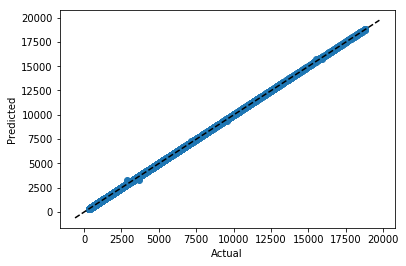

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
display_model_performance("Decision Tree Regression", tree_reg)

### Random Forest Regression

RMSE: 237.9667
CV-RMSE: 577.3906
--- Test Performance ---
RMSE: 282.6978
Accuracy: 99.5%
Predictions:	 [ 848.8 6193.2 2045.3 7909.5 5302.4  529.8 5243.5]
Labels:		 [877.0, 6362.0, 1982.0, 7459.0, 4890.0, 540.0, 5141.0]


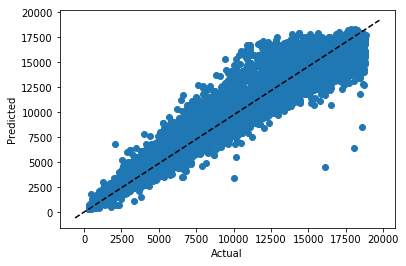

------- Test -------


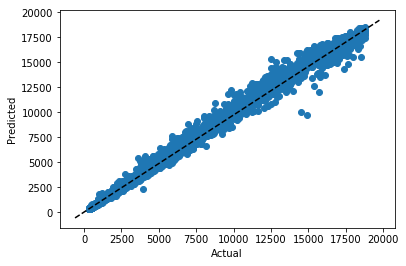

In [31]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators = 10, random_state = 42)
display_model_performance("Random Forest Regression", forest_reg)

### Ridge Regression

RMSE: 1782.0191
CV-RMSE: 1783.2610
--- Test Performance ---
RMSE: 1785.6677
Accuracy: 80.12%
Predictions:	 [4182.33628753 1364.63884821 4156.44547086 5545.60933263 1696.00412767
 2791.79558919  971.58838345]
Labels:		 [3103.0, 1243.0, 3243.0, 5038.0, 1163.0, 1734.0, 1033.0]


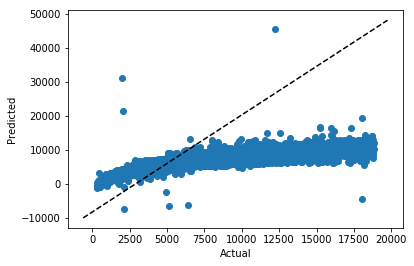

------- Test -------


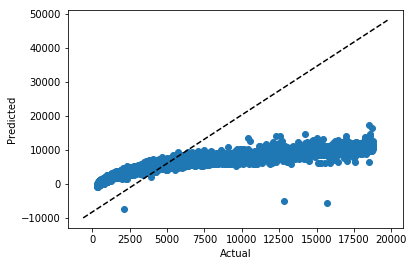

In [32]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(normalize = True)
display_model_performance("Ridge Regression", ridge_reg)

### Lasso Regression

RMSE: 1401.3031
CV-RMSE: 1387.4085
--- Test Performance ---
RMSE: 1255.4279
Accuracy: 90.17%
Predictions:	 [-119.00506612 5329.81582168 -468.68419027 6716.89478251  500.7485173
 4382.03884766 1319.23450109]
Labels:		 [419.0, 5101.0, 572.0, 9257.0, 702.0, 4127.0, 1040.0]


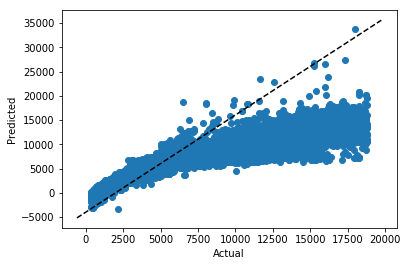

------- Test -------


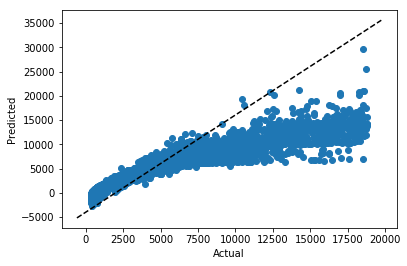

In [33]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(normalize = True)
display_model_performance("Lasso Regression", lasso_reg)

### Elastic Net Regression

RMSE: 1725.9555
CV-RMSE: 1727.3482
--- Test Performance ---
RMSE: 1735.8126
Accuracy: 81.22%
Predictions:	 [4020.85455992 9927.52585911 1462.55831105  784.14016684 5980.69636672
  992.59712354 2834.22103288]
Labels:		 [3012.0, 17492.0, 1259.0, 628.0, 3783.0, 842.0, 2052.0]


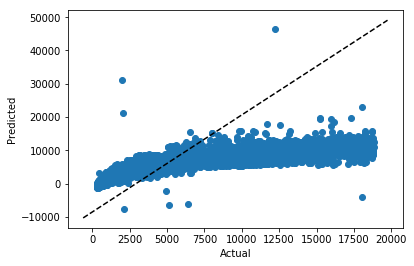

------- Test -------


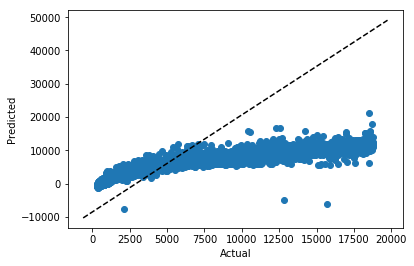

In [34]:
from sklearn.linear_model import ElasticNet

net_reg = ElasticNet()
display_model_performance("Elastic Net Regression", net_reg)

### AdaBoost Regression

RMSE: 1508.5113
CV-RMSE: 1475.1597
--- Test Performance ---
RMSE: 1475.8491
Accuracy: 86.42%
Predictions:	 [ 3193.75409836  3507.4516129  12885.55874864  4655.7252459
  1671.37697517  1671.37697517  3795.67874396]
Labels:		 [1865.0, 3191.0, 10521.0, 3841.0, 552.0, 805.0, 2590.0]


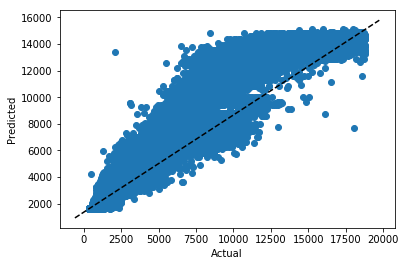

------- Test -------


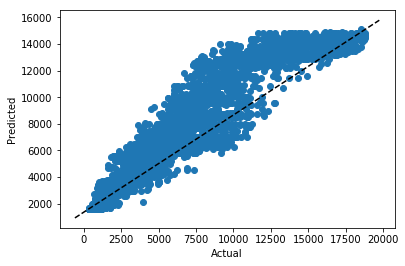

In [35]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators = 100)
display_model_performance("AdaBoost Regression", ada_reg)

### GradientBoosting Regression

RMSE: 1229.1191
CV-RMSE: 1235.6116
--- Test Performance ---
RMSE: 1242.2006
Accuracy: 90.38%
Predictions:	 [1084.6442308   971.60572414 5467.55240227 1084.6442308  1217.70154312
 5798.33374292 2956.01061982]
Labels:		 [675.0, 824.0, 3980.0, 1041.0, 1079.0, 5743.0, 4951.0]


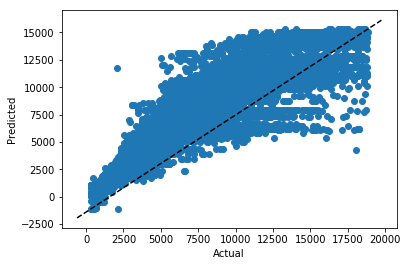

------- Test -------


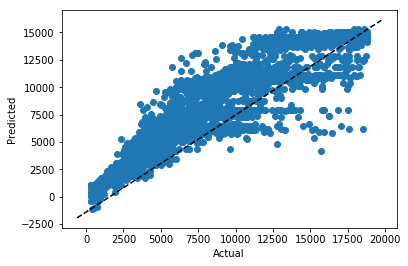

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

grad_reg = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1,
                                     max_depth = 1, random_state = 42, loss = 'ls')
display_model_performance("GradientBoosting Regression", grad_reg)

## Compare Models Performance

In [43]:
compare_models = pd.DataFrame({ "Algorithms": models, "Models RMSE": models_rmse, "CV RMSE Mean": cvs_rmse_mean,
                              "Tests RMSE": tests_rmse, "Tests Accuracy": tests_accuracy })
compare_models.sort_values(by = "Tests Accuracy", ascending = False)

,Algorithms,Models RMSE,CV RMSE Mean,Tests RMSE,Tests Accuracy
1,Decision Tree Regression,8.613424,742.145838,6.555155,100.00
2,Random Forest Regression,237.966731,577.390633,282.697751,99.50
0,Linear Regression,1124.813676,1126.375637,1142.256345,91.87
7,GradientBoosting Regression,1229.119083,1235.611606,1242.200607,90.38
4,Lasso Regression,1401.303082,1387.408507,1255.427883,90.17
6,AdaBoost Regression,1508.511294,1475.159694,1475.849104,86.42
5,Elastic Net Regression,1725.955500,1727.348165,1735.812583,81.22
3,Ridge Regression,1782.019095,1783.261042,1785.667741,80.12


Okay. I was really surprised seeing some **100% accuracy** from the `Decision Tree Regression `Model. That is just too perfect. Noticed that some dataset from the test set were selected and compared and that was just right!

Another model that we could depend on is the `Random Forest Regression`. It works relatively fine in my opinion.

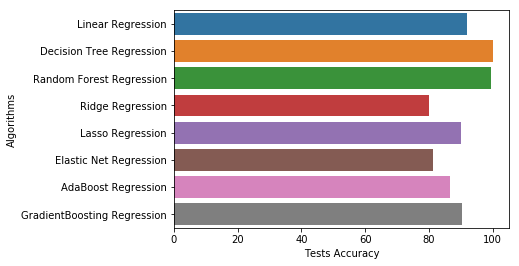

In [38]:
sns.barplot(x = "Tests Accuracy", y = "Algorithms", data = compare_models)
plt.show()

## Save model

In [39]:
import pickle

with open('final_model.pkl', 'wb') as f:
    pickle.dump(tree_reg, f)

## Conclusion

The **Decision Tree Algorithm** wins it all here!

What do you think about the deduced model? Could it really be? Please comment your opinions.

That's all for now. I'm still learning, so I would love some feedback!

**If you find this notebook useful, Please upvote this notebook it keeps me motivated.** Also I do look forward to suggestions, so please comment if any. Thank you!